# Introduction

Comme demande par Open Classrooms, je ne livre qu'un seul Notebook. Cependant, ce notebook en contient deux en un :
1. Une partie qui s'execute depuis un cluster EMR AWS, qui va recuperer des images pour les vectoriser. Puis, on execute une ACP dont on sauvegarde la sortie et le modele associe dans S3.
2. Une partie dediee a la data visualisation, qui, elle, est executee depuis mon IDE locale que j'ai connecte a AWS S3 pour pouvoir recuperer les elements precedemment generes.


# -- AWS EXECUTION --

# Code existant

Ce code est extrait du Notebook fournit par le stagiaire. Il permet le traitement des images via le modele MobileNetV2 et sauvegarde les vecteurs des images dans le bucket S3 qu'on aura nous-meme configure

In [1]:
# L'exécution de cette cellule démarre l'application Spark

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1690277538906_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1690277538906_0003,pyspark,idle,Link,Link,✔


## 0. Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

## 1. Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://oc-ds-p8-fruits'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-ds-p8-fruits
PATH_Data:   s3://oc-ds-p8-fruits/Test
PATH_Result: s3://oc-ds-p8-fruits/Results

## 3. Traitement des données

### 3.1. Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://oc-ds-p8-fru...|2023-07-06 11:12:23|  7353|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-06 11:12:24|  7350|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-06 11:12:23|  7349|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-06 11:12:24|  7348|[FF D8 FF E0 00 1...|
|s3://oc-ds-p8-fru...|2023-07-06 11:12:29|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------+----------+
|path                                              |label     |
+--------------------------------------------------+----------+
|s3://oc-ds-p8-fruits/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://oc-ds-p8-fruits/Test/Watermelon/r_95_100.jpg |Watermelon|
+--------------------------------------------------+----------+
only showing top 5 rows

None

### 3.2. Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14540800/14536120 [==============================] - 1s 0us/step

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 3.3. Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

### 3.4. Exécutions des actions d'extractions de features

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-ds-p8-fruits/Results

In [17]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# CUSTOM CODE

# Chargement des fichiers

Le code initiale chargeait les fichiers parquet avec un Dataframe Pandas. Il semblait plus pertinent de directement travailler dans un environnement PySpark.

In [18]:
df_source = spark.read.parquet(PATH_Result)
df_source.select('features').show(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[0.4741057, 0.428...|
|[0.41570547, 0.30...|
|[0.0, 0.05406629,...|
+--------------------+
only showing top 3 rows

In [19]:
df_source.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

On convertit le tableau de reels en VectorUDT pour pouvoir ensuite utiliser les librairies ML de PySpark

In [20]:
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Les données images sont converties au format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
df = df_source.withColumn('features', ud_f('features'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)

# ACP

## 1. Standard Scaling

In [22]:
from pyspark.ml.feature import StandardScaler

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
standardizer = StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
scalerModel = standardizer.fit(df)
scaled_data = scalerModel.transform(df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. PCA fit & transform

On va prendre les 10 premieres composantes principales afin de pouvoir tracer une scree plot un peu interessante.

In [24]:
from pyspark.ml.feature import PCA

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
k=10
pca = PCA(k=k, inputCol="scaled_features") 
pca.setOutputCol("pca_features")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PCA_4b3927ada856

In [26]:
model = pca.fit(scaled_data)
model.getK()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10

In [27]:
output_df = model.transform(scaled_data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
print("Type output PCA transform : ", type(output_df))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Type output PCA transform :  <class 'pyspark.sql.dataframe.DataFrame'>

In [29]:
output_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- pca_features: vector (nullable = true)

In [30]:
pca_features = output_df.select('pca_features').collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
print("Collected PCA_FEATURES caracteristiques")
print("----------------------------------------------")
print("Type : ", type(pca_features))
print("Taille : ", len(pca_features))
print("Type item[0] : ", type(pca_features[0]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Collected PCA_FEATURES caracteristiques
----------------------------------------------
Type :  <class 'list'>
Taille :  22688
Type item[0] :  <class 'pyspark.sql.types.Row'>

## 3. Save outputs

On va enregistrer les 10 premieres composantes principales, de manieres a pouvoir les analyser dans un environnement dedie a la visualisation

In [32]:
pca_features[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(pca_features=DenseVector([-9.5938, 4.8681, -5.5766, -2.3354, 1.2726, 3.6109, -1.6245, 9.5065, 3.2059, -5.8386]))

In [33]:
def transform_list_of_vect_to_df(vectlist) :
    return pd.DataFrame([[vectlist[j][0][i] for i in range(k)] for j in range(len(vectlist))])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
transform_list_of_vect_to_df(pca_features).head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           0         1         2  ...         7         8         9
0  -9.593844  4.868111 -5.576569  ...  9.506469  3.205945 -5.838603
1 -13.679494  8.184227 -4.858718  ...  3.056938  6.238023 -8.077323

[2 rows x 10 columns]

_pca features_ ce sont les coordonnees de nos points dans notre nouveau referentiel definis par les vecteurs des composantes principales. Chaque point de donnee est exprime selon les k axes de nos CP.

In [53]:
pca_coord = transform_list_of_vect_to_df(pca_features)
pca_coord.head(2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

           0         1         2  ...         7         8         9
0  -9.593844  4.868111 -5.576569  ...  9.506469  3.205945 -5.838603
1 -13.679494  8.184227 -4.858718  ...  3.056938  6.238023 -8.077323

[2 rows x 10 columns]

In [54]:
type(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pandas.core.frame.DataFrame'>

In [55]:
pca_coord = pca_coord.rename(columns={0: "pc1", 1: "pc2", 2: "pc3", 3: "pc4", 4: "pc5", 5: "pc6", 6: "pc7", 7: "pc8", 8: "pc9", 9: "pc10"})

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [56]:
pys_pca_coord = spark.createDataFrame(pca_coord)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
# Save coordinates
PATH_PCA_Result = PATH+'/PCA_outputs'
pys_pca_coord.write.mode("overwrite").parquet(PATH_PCA_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
# Save Model
model.save(PATH+'/PCA_model/pca_model')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# -- LOCAL EXECUTION --

L'environnement PySpark AWS est peu propice a l'ajout de divers librairie necessaire a la visualisation, sans compter que l'interface du Jupyter Hub est bien moins lechee que l'environnement PyCharm Pro que je me suis offert en debut de formation. Il m'a donc semble plus opportun de travailler la visualisation et l'analyse des resultats depuis mon IDE habituel, en etablissant une communication avec AWS S3 pour recuperer les fichiers generes precedemment.

Par ailleurs, distinguer les interfaces de recueille et de processing des donnees me paraissait assez coherent avec les architectures lambda.

## 4. PCA Analysis

### 4.1. Recuperation des donnees sur S3

In [1]:
import os

print("SPARK_HOME :", os.environ['SPARK_HOME'])
print("JAVA_HOME : ", os.environ['JAVA_HOME'])

SPARK_HOME : /opt/spark-3.2.4-bin-hadoop2.7
JAVA_HOME :  /opt/jdk/jdk1.8.0_202


#### Recuperation des dataframes

In [2]:
import s3fs
import fastparquet as fp

def get_s3_parquet_data(parent_folder = "oc-ds-p8-fruits/PCA_outputs") :
    s3_ref = s3fs.S3FileSystem()
    fs_ref = s3fs.core.S3FileSystem()

    #mybucket/data_folder/serial_number=1/cur_date=20-12-2012/abcdsd0324324.snappy.parquet
    s3_parquet_path = parent_folder+"/*.parquet"
    all_paths_from_s3_parquet = fs_ref.glob(path=s3_parquet_path)

    open_connec = s3_ref.open
    #use s3fs as the filesystem
    fp_objet = fp.ParquetFile(all_paths_from_s3_parquet, open_with=open_connec)
    #convert to pandas dataframe
    df_output = fp_objet.to_pandas()
    return df_output

In [3]:
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .getOrCreate()
)

23/07/26 15:45:33 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.1.15 instead (on interface wlp0s20f3)
23/07/26 15:45:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/26 15:45:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df_vectorized_images = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/Results")
df_vectorized_images.head(2)

,path,label,features
0,s3://oc-ds-p8-fruits/Test/Watermelon/r_99_100.jpg,Watermelon,"[0.01771676, 0.23936023, 0.0, 0.0, 0.5658412, ..."
1,s3://oc-ds-p8-fruits/Test/Pineapple Mini/293_1...,Pineapple Mini,"[0.0, 4.803104, 0.021533662, 0.0, 0.0, 0.0, 0...."


In [5]:
df_pca_output = get_s3_parquet_data(parent_folder="oc-ds-p8-fruits/PCA_outputs")
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-9.593844,4.868111,-5.576569,-2.335435,1.272555,3.610870,-1.624478,9.506469,3.205945,-5.838603
1,-13.679494,8.184227,-4.858718,-1.920020,0.850164,-0.016279,-5.880775,3.056938,6.238023,-8.077323


#### Recuperation du model

### 4.2. Analyses visuelles

#### Scree Plot

In [7]:
# v_explained_variance = model.explainedVariance
# v_explained_variance

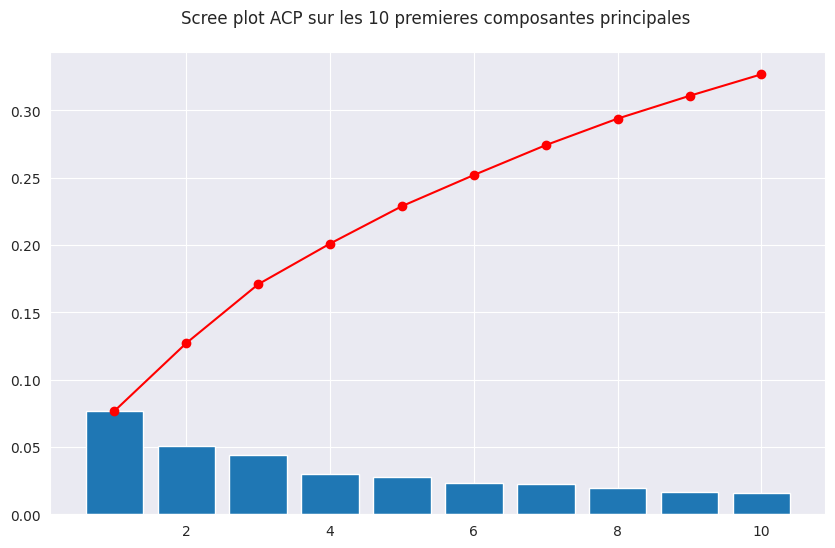

In [8]:
import matplotlib.pyplot as plt
import numpy as np
k=10
# Les valeurs ci-apres ont ete obtenu avec la cellule ci-dessus, lors de l'execution sur AWS.
scree_values = [0.0767, 0.0504, 0.0437, 0.0302, 0.0278, 0.0231, 0.0222, 0.0197, 0.0169, 0.016]

x_list = range(1, k+1)
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree_values)
plt.plot(x_list, np.cumsum(scree_values), color='r', marker='o')
plt.title(f"Scree plot ACP sur les {k} premieres composantes principales \n")
plt.show()

Le coude semble apparaitre a 3 dimensions.

On va donc s'essayer a deux visualisation :
1. Une sur deux dimensions, car c'est simple et visuel
2. Une sur trois dimensions, car cela semble pertinent selon la scree plot ci-dessus.

#### Visualisation dans les espaces vectorielles des PC

In [9]:
df_pca_output['label'] = df_vectorized_images['label']
df_pca_output['cat_label'] = [nom.split(' ')[0] for nom in df_pca_output['label'].values]
df_pca_output.head(4)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label
0,-9.593844,4.868111,-5.576569,-2.335435,1.272555,3.610870,-1.624478,9.506469,3.205945,-5.838603,Watermelon,Watermelon
1,-13.679494,8.184227,-4.858718,-1.920020,0.850164,-0.016279,-5.880775,3.056938,6.238023,-8.077323,Pineapple Mini,Pineapple
2,-8.007939,7.428822,-2.929376,-3.722762,-0.902141,2.023908,-2.838196,0.846654,3.438488,-3.203783,Cauliflower,Cauliflower
3,-5.785983,8.066395,-4.750717,-3.257624,-0.684165,1.064893,-0.754032,1.254455,3.251560,-5.099625,Cauliflower,Cauliflower


In [10]:
import seaborn as sns

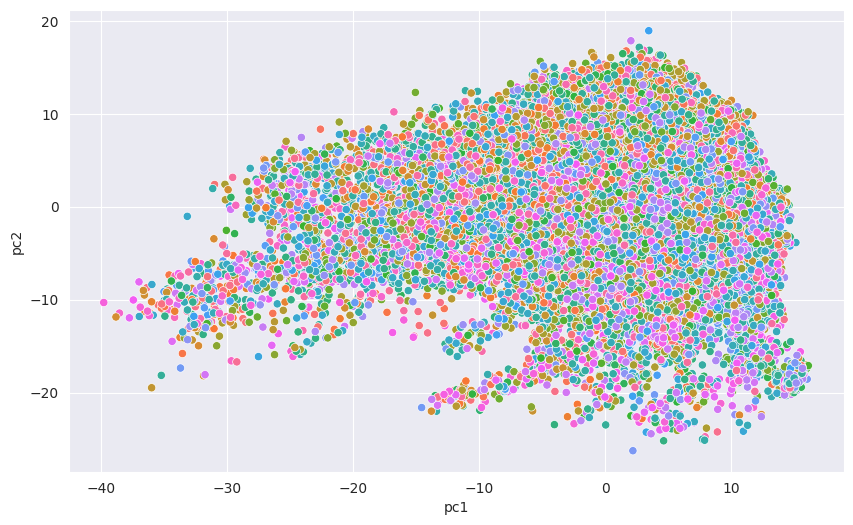

In [11]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='label')
g.legend([],[], frameon=False)
plt.show()

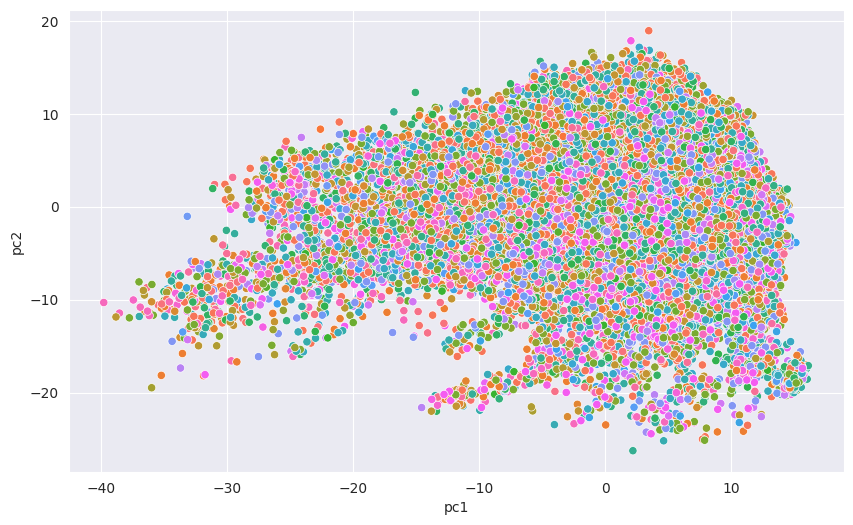

In [12]:
plt.figure(figsize=(10, 6))
g = sns.scatterplot(data=df_pca_output, x="pc1", y="pc2", hue='cat_label')
g.legend([],[], frameon=False)
plt.show()

In [13]:
import pandas as pd
df_pca_output.cat_label = pd.Categorical(df_pca_output.cat_label)
df_pca_output['code'] = df_pca_output.cat_label.cat.codes
df_pca_output.head(2)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,label,cat_label,code
0,-9.593844,4.868111,-5.576569,-2.335435,1.272555,3.610870,-1.624478,9.506469,3.205945,-5.838603,Watermelon,Watermelon,66
1,-13.679494,8.184227,-4.858718,-1.920020,0.850164,-0.016279,-5.880775,3.056938,6.238023,-8.077323,Pineapple Mini,Pineapple,50


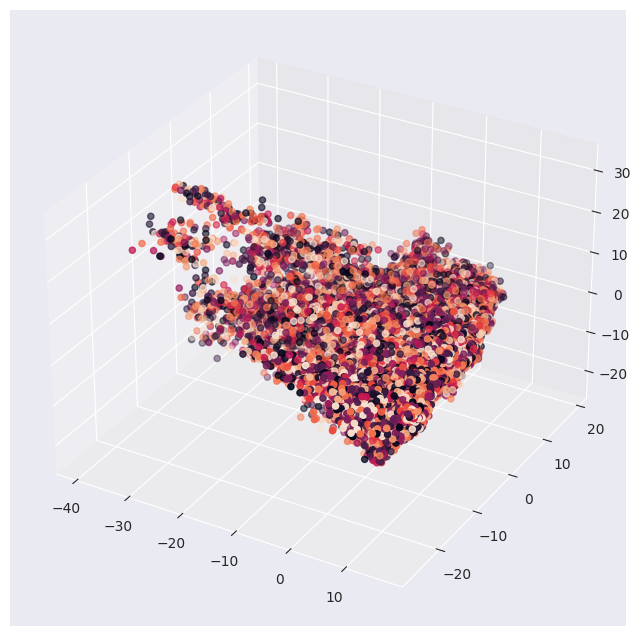

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 8))

ax = plt.axes(projection='3d')

zdata = df_pca_output['pc3']
xdata = df_pca_output['pc1']
ydata = df_pca_output['pc2']
ax.scatter3D(xdata, ydata, zdata,c=df_pca_output['code']);

plt.show()

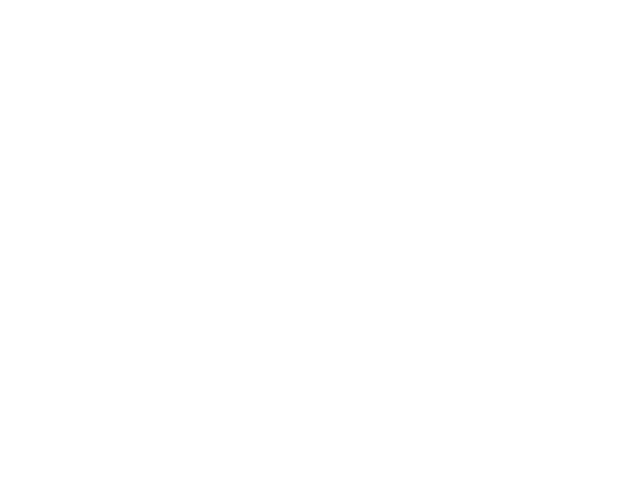

In [17]:
# for creating a responsive plot
%matplotlib widget

# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# creating random dataset
xs = df_pca_output['pc1']

ys = df_pca_output['pc2']

zs = df_pca_output['pc2']

# creating figure
fig = plt.figure()
ax = Axes3D(fig)

# creating the plot
plot_geeks = ax.scatter(xs, ys, zs, color='green')

# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')

# displaying the plot
plt.show()